In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
from sklearn import metrics
# from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon, euclidean

In [4]:
def dist(A, B, method = "js"):
    aCols = list(A.columns)
    bCols = list(B.columns)
    aRows = list(A.index)
    bRows = list(B.index)
    intersectCols = list(set(aCols) & set(bCols))
    intersectRows = list(set(aRows) & set(bRows))

    A = A.loc[intersectRows, intersectCols]
    B = B.loc[intersectRows, intersectCols]
    A = A.fillna(0)
    B = B.fillna(0)
    
    if method == 'ed':
        distList = [ed(A[sample].to_numpy().astype(np.float32), B[sample].to_numpy().astype(np.float32))
                    for sample in intersectCols]
    elif method == 'js':
        distList = [js(A[sample].to_numpy().astype(np.float32), B[sample].to_numpy().astype(np.float32))
                    for sample in intersectCols]
    else:
        distList = [ks(A[sample].to_numpy().astype(np.float32), B[sample].to_numpy().astype(np.float32))
                    for sample in intersectCols]
    dists = pd.Series(distList)
    dists.index = intersectCols
    return(dists)

In [5]:
def ed(a, b):
    if len(a) != len(b):
        print("The two arrays are not same size!")
    if np.sum(a) == 0 or np.sum(b) == 0:
        return(np.nan)
    a /= np.sum(a)
    b /= np.sum(b)
    dist = euclidean(a, b)
    return(dist)


def js(a, b):
    if len(a) != len(b):
        print("The two arrays are not same size!")
    if np.sum(a) == 0 or np.sum(b) == 0:
        return(np.nan)
    a /= np.sum(a)
    b /= np.sum(b)
    dist = jensenshannon(a, b)
    return(dist)


def ks(a, b):
    if len(a) != len(b):
        print("The two arrays are not same size!")
    if np.sum(a) == 0 or np.sum(b) == 0:
        return(np.nan)     
    a /= np.sum(a)
    b /= np.sum(b)
    dist = np.amax(np.abs(np.cumsum(a) - np.cumsum(b)))
    return(dist)

In [85]:
algs = ["cibersort", "mcpcounter", "epic", "xcell"]
sigs = ["LM22", "LM7c", "LM9", "PBMC"]
distTypes = ["ed", "js", "ks"]
cancerTypes = ["brca", "ccrcc", "colon", "endometrial", "hnscc", "luad", "ovarian"]
for distType in distTypes:
    for sig in sigs:
        for cancerType in cancerTypes:
            matrix = []
            for algA in algs:
                tempM = []
                for algB in algs:
                    mA = pd.read_csv("../fig4/data/" + cancerType + "-all-mrna-raw-" + algA + "-" + sig + ".tsv", sep='\t', index_col=0)
                    mB = pd.read_csv("../fig4/data/" + cancerType + "-all-prot-raw-" + algB + "-" + sig + ".tsv", sep='\t', index_col=0)
                    tempM.append(dist(mA, mB, distType))
                matrix.append(tempM)
            matrix = np.array(matrix)
            ax = plt.figure()
            ax = sns.heatmap(matrix, cmap='coolwarm', annot = True, xticklabels = algs, yticklabels = algs)
            ax.set_title(cancerType + '-' + sig + '-' + distType)
            ax.get_figure().savefig(distType + '-' + sig + '-' + cancerType + ".pdf", bbox_inches='tight')
            plt.close()

In [6]:
algs = ["cibersort", "mcpcounter", "epic", "xcell"]
sigs = ["LM22", "LM7c", "LM9", "PBMC"]
distTypes = ["ed", "js", "ks"]
cancerTypes = ["brca", "ccrcc", "colon", "endometrial", "hnscc", "luad", "ovarian"]
df = []
for distType in distTypes:
    for sig in sigs:
        for cancerType in cancerTypes:
            for algA in algs:
                for algB in algs:
                    mA = pd.read_csv("../fig4/data/" + cancerType + "-all-mrna-raw-" + algA + "-" + sig + ".tsv", sep='\t', index_col=0)
                    mB = pd.read_csv("../fig4/data/" + cancerType + "-all-prot-raw-" + algB + "-" + sig + ".tsv", sep='\t', index_col=0)
                    dists = dist(mA, mB, distType)
                    dists.to_csv("../fig4/data/mrna-raw-vs-prot-raw-dists/all-" + cancerType + "-" + algA + "-to-" + algB + "-" + sig + "-" + distType + "-dist.tsv", sep='\t', header=False)
                    distance = np.sqrt(np.sum(dists.values ** 2))
                    df.append([distance, distType, sig, cancerType, algA, algB])

In [88]:
dfs = pd.DataFrame(df)
dfs.columns = ["Dist", "DistType", "SigMatrix", "CancerType", "AlgRna", "AlgProt"]
dfs

,Dist,DistType,SigMatrix,CancerType,AlgRna,AlgProt
0,5.253586,ed,LM22,brca,cibersort,cibersort
1,4.143607,ed,LM22,brca,cibersort,mcpcounter
2,5.565685,ed,LM22,brca,cibersort,epic
3,3.974166,ed,LM22,brca,cibersort,xcell
4,6.202576,ed,LM22,brca,mcpcounter,cibersort
...,...,...,...,...,...,...
1339,5.951001,ks,PBMC,ovarian,epic,xcell
1340,4.668884,ks,PBMC,ovarian,xcell,cibersort
1341,1.459021,ks,PBMC,ovarian,xcell,mcpcounter
1342,4.022251,ks,PBMC,ovarian,xcell,epic


<AxesSubplot:xlabel='SigMatrix', ylabel='Dist'>

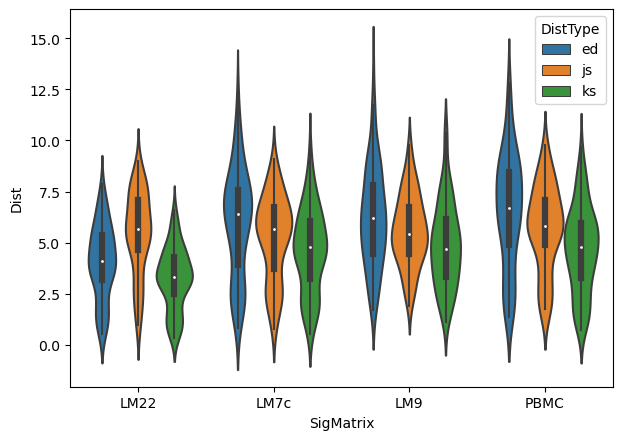

In [91]:
sns.violinplot(x="SigMatrix", y = "Dist", hue="DistType", data = dfs)

/Users/feng626/anaconda3/envs/omics/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/feng626/anaconda3/envs/omics/lib/python3.8/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


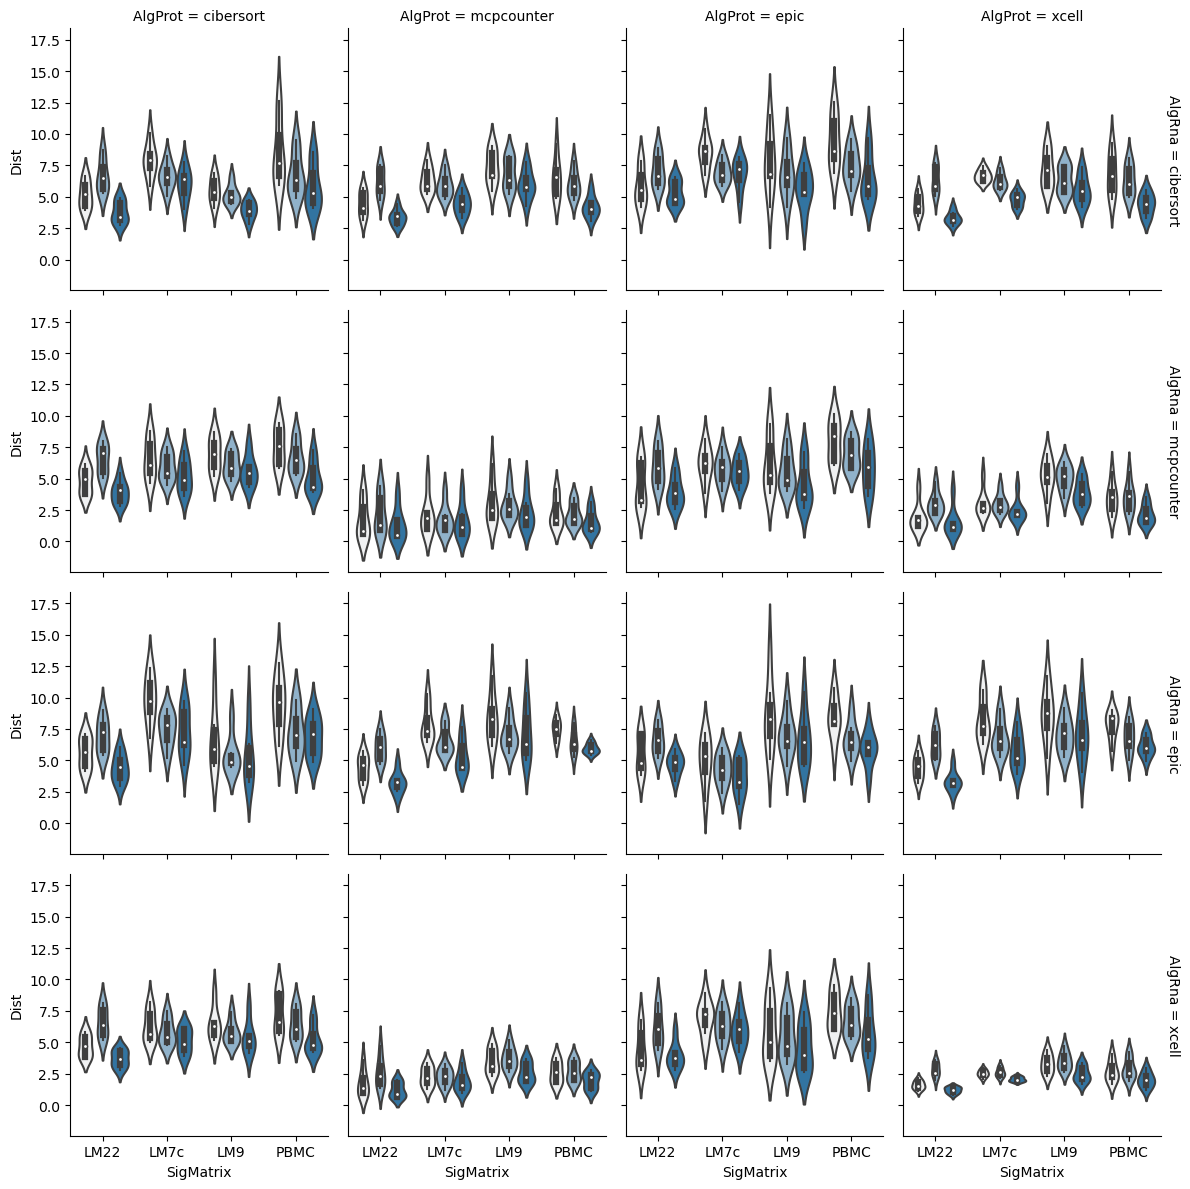

In [101]:
g = sns.FacetGrid(dfs, row="AlgRna", col="AlgProt", margin_titles=True)
g.map(sns.violinplot, "SigMatrix", "Dist", "DistType")

In [8]:
algs = ["cibersort", "mcpcounter", "epic", "xcell"]
sigs = ["LM22", "LM7c", "LM9", "PBMC"]
distTypes = ["ed", "js", "ks"]
cancerTypes = ["brca", "ccrcc", "colon", "endometrial", "hnscc", "luad", "ovarian"]
for distType in distTypes:
    for sig in sigs:
        for cancerType in cancerTypes:
            for i in range(len(algs)):
                for j in range(len(algs)):
                    if i > j:
                        mA = pd.read_csv("../fig4/data/" + cancerType + "-all-mrna-raw-" + algs[i] + "-" + sig + ".tsv", sep='\t', index_col=0)
                        mB = pd.read_csv("../fig4/data/" + cancerType + "-all-mrna-raw-" + algs[j] + "-" + sig + ".tsv", sep='\t', index_col=0)
                    elif i < j:
                        mA = pd.read_csv("../fig4/data/" + cancerType + "-all-prot-raw-" + algs[i] + "-" + sig + ".tsv", sep='\t', index_col=0)
                        mB = pd.read_csv("../fig4/data/" + cancerType + "-all-prot-raw-" + algs[j] + "-" + sig + ".tsv", sep='\t', index_col=0)
                    else:
                        mA = pd.read_csv("../fig4/data/" + cancerType + "-all-mrna-raw-" + algs[i] + "-" + sig + ".tsv", sep='\t', index_col=0)
                        mB = pd.read_csv("../fig4/data/" + cancerType + "-all-prot-raw-" + algs[j] + "-" + sig + ".tsv", sep='\t', index_col=0)
                    dists = dist(mA, mB, distType)
                    dists.to_csv("../fig4/data/compareAll/all-" + cancerType + "-" + algs[i] + "-to-" + algs[j] + "-" + sig + "-" + distType + "-dist.tsv", sep='\t', header=False)